In [1]:
# my_functions contains the pre-defined custom functions to avoid defining again during modelling and predicting process
# The module needs to be copied to the working directory so we can access it
from shutil import copyfile
copyfile(src='../input/foursquare-my-data/my_functions.py', dst='../working/my_functions.py')

'../working/my_functions.py'

In [2]:
import numpy as np
import pandas as pd
import Levenshtein
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.5/926.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=102012 sha256=2fec395cba93f0046a56e52393c19b322251b2089aa445d5101efcf4a66540ee
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jaconv: filename=jaconv-0.3-py3-none-any.whl size=15564 sha256=07e63d97e38eccdcf87ff07f0d9fbda5f284406f1de1964e4ac3fe193ede138a
  Stored in directory: /root/.cache/pip/wheels/8f/4f/c2/a2a3b14d0e94f855f4aa8887bf0267bee9ecfb8e62a9ee2d92
Successfully built jaconv


In [3]:
# Show all columns in output shells
pd.set_option('display.max_columns', None)

# Load training dataset

In [4]:
train_df = pd.read_csv('../input/foursquare-location-matching/train.csv', index_col='id')
train_df.head()

,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
id,,,,,,,,,,,,
E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


# EDA - exploring the raw data

In [5]:
# Explore missing values
train_df.isna().sum().sort_values()

latitude                  0
longitude                 0
point_of_interest         0
name                      1
country                  11
categories            98307
city                 299189
address              396621
state                420586
zip                  595426
phone                795957
url                  871088
dtype: int64

In [6]:
# Missing values in percentage
train_df.isna().sum().sort_values() / len(train_df) * 100

latitude              0.000000
longitude             0.000000
point_of_interest     0.000000
name                  0.000088
country               0.000966
categories            8.632417
city                 26.272027
address              34.827610
state                36.931996
zip                  52.284837
phone                69.893626
url                  76.490940
dtype: float64

Among all columns, 'latitude', 'longitude', 'name' and 'country' have relatively few missing values, so they are more reliable for blocking.

In [7]:
# More information of the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1138812 entries, E_000001272c6c5d to E_ffffe6f4652fbb
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1138811 non-null  object 
 1   latitude           1138812 non-null  float64
 2   longitude          1138812 non-null  float64
 3   address            742191 non-null   object 
 4   city               839623 non-null   object 
 5   state              718226 non-null   object 
 6   zip                543386 non-null   object 
 7   country            1138801 non-null  object 
 8   url                267724 non-null   object 
 9   phone              342855 non-null   object 
 10  categories         1040505 non-null  object 
 11  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(10)
memory usage: 112.9+ MB


Apart from 'latitude' and 'longitude', all columns contain string values.

In [8]:
# Explore the total number of POIs
npoi = len(pd.unique(train_df['point_of_interest']))
print('Number of POIs:', npoi)

Number of POIs: 739972


In [9]:
# Explore number of place entries in each countries
ncountries = train_df['country'].value_counts()
ncountries

US    245284
TR    115177
ID    110796
JP     70032
TH     58808
       ...  
BV         1
GY         1
PM         1
SS         1
VU         1
Name: country, Length: 221, dtype: int64

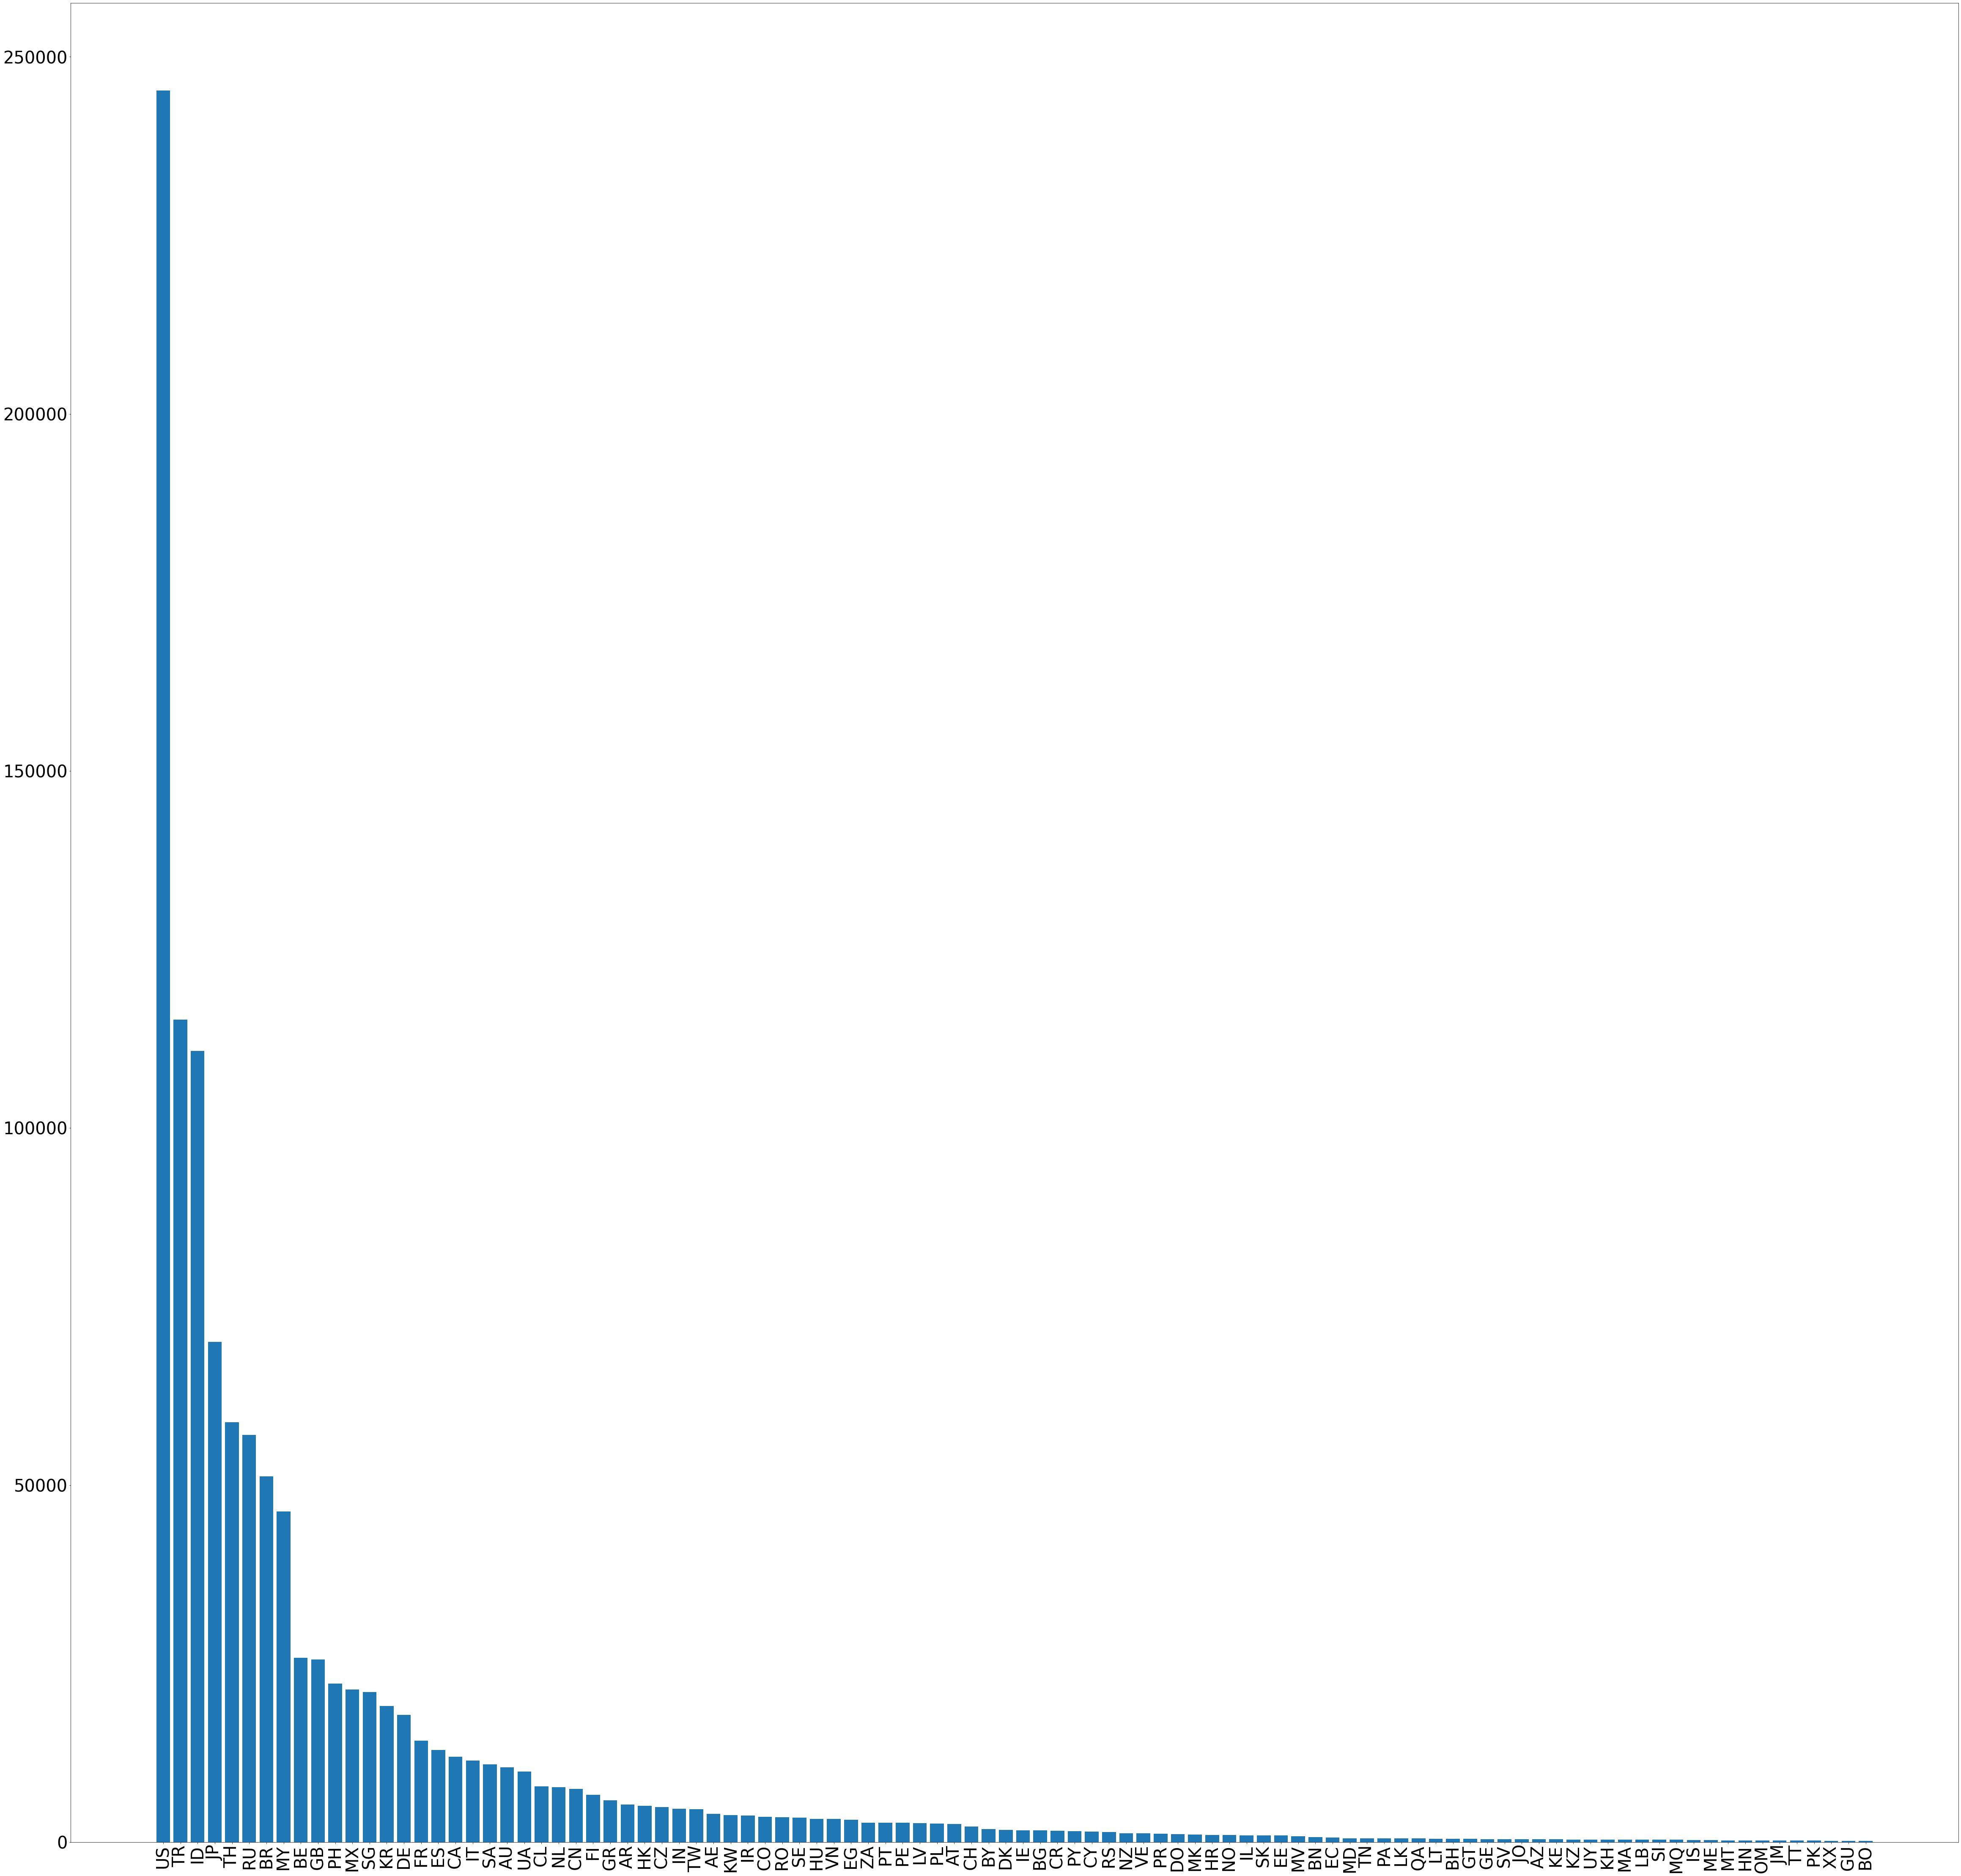

In [10]:
# Visualize first 100 countries with most place entries
plt.figure(figsize=(80, 80))
plt.bar(ncountries[:100].index, ncountries[:100].values)
plt.xticks(rotation=90, fontsize=40)
plt.yticks(fontsize=40)
plt.show()

Place entries are very concentrated in some countries despite there are 221 countries in total.

In [11]:
# Explore the noises in the dataset
train_df[train_df['point_of_interest'] == 'P_72c2656b5de214']

,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
id,,,,,,,,,,,,
E_8256ac1bcf1ef5,Griya Tegal Wangi Asri,-8.691548,115.223665,Jln Tukad Tegal Wangi,Denpasar,Indonesia,80223,ID,NaN,NaN,Temples,P_72c2656b5de214
E_8da2f96f24318f,Padmasana Griya Tegal Wangi Asri,39.720000,-105.120000,Perumahan Tegal Wangi Asri,Denpasar,CO,80225,US,NaN,NaN,Temples,P_72c2656b5de214


The above 2 entries are pointing to the same POI. We can see 2 records look quite difficult in their name, address and even in latitude, longitude and country. It is clear that the dataset is full of noises.

In [12]:
# Explore entities in Japan
train_df[train_df['country'] == 'JP'].head(20)

,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
id,,,,,,,,,,,,
E_0000c566a81ea1,つじ田 味噌の章,35.694796,139.767348,神田小川町1-1,千代田区,東京都,101-0052,JP,https://tsukemen-tsujita.com,366597676,Ramen Restaurants,P_5fcd8cd98fea2b
E_00014f107dc217,ローソン 弘前撫牛子店,40.623279,140.494751,撫牛子2-10ｰ2,弘前市,青森県,036-8075,JP,http://www.lawson.co.jp,172325353,Convenience Stores,P_d0bb3bdad1ab4f
E_000184ea12d0f0,ざま駅前歯科医院,35.480396,139.400101,入谷東3-60-2,座間市,神奈川県,252-0028,JP,https://www.z-shika.com,+81462666868,Dentist's Offices,P_c10c14a0485c42
E_00020dcc3c836f,下高井戸 どどん,35.666125,139.640393,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_4906c743fba448
E_000292dce833cc,虎萬元 南青山店,35.658947,139.716830,南青山7-8-4,Minato,Tōkyō,107-0062,JP,NaN,NaN,Cantonese Restaurants,P_83149f585ae7a9
E_0002b0ae551c83,イオン乙金ショッピングセンター,33.543487,130.496612,乙金3-23-1 / 乙金3-24-1,大野城市,福岡県,816-0902,JP,http://otogana.aeonkyushu.com,+81925130150,Shopping Malls,P_5d862c5c2d0f5b
E_000587836c4320,甲武信小屋,35.907158,138.730793,大滝3638-8,秩父市,埼玉県,369-1901,JP,http://www.kobusi.com,+819033378947,Mountain Huts,P_2df954ead21e1f
E_00065d23dbbec8,ロイヤル キッチン 京都高島屋店,35.003274,135.769077,下京区真町52,京都市,京都府,600-8520,JP,NaN,+81752218862,Restaurants,P_db73556a56c96f
E_0006a5fa76742d,博多らーめん四神,35.950399,139.992471,中央3-2,守谷市,茨城県,302-0115,JP,http://www.nre.co.jp,0297461863,Ramen Restaurants,P_e21b9d3b49372d


We may have to preprocess the Japanese entries because the languages of presentation are not quite consistent.

# Data preprocessing and feature engineering

In [13]:
# Convert Japanese characters into Romaji (English)
train_df = convert_japanese_alphabet(train_df)

In [14]:
# Preprocess text columns that will be used
text_preprocess(train_df)

# EDA - insight from pairs
After analysing the raw data, we want to know if 2 place entries match, how similar they are in terms of some features. So first we have to get the pairs that are having the same POIs ("point_of_interest" column values) because according to the competition host, this  is the only feature that validates whether a record is a duplicate. 

Although there is a pregenerated pairs.csv from official dataset, it is not complete so I will generate one by myself.

In [15]:
# Create a special version of train_df for the purpose of matching pairs
train_reset_index = train_df.reset_index()

# Self-merge training dataset on 'point_of_interest'
# It returns all matching pairs including themselves (that means entities will self-match)
pairs_from_train = train_reset_index.merge(train_reset_index, on='point_of_interest', how='left')

# If 2 ids are the same, they should be removed because they are actually the same entity
pairs_from_train = pairs_from_train[pairs_from_train['id_x'] != pairs_from_train['id_y']]

In [16]:
pairs_from_train.head()

,id_x,name_x,latitude_x,longitude_x,address_x,city_x,state_x,zip_x,country_x,url_x,phone_x,categories_x,point_of_interest,name_loc_x,id_y,name_y,latitude_y,longitude_y,address_y,city_y,state_y,zip_y,country_y,url_y,phone_y,categories_y,name_loc_y
1,E_000001272c6c5d,café stad oudenaarde,50.859975,3.634196,abdijstraat,nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,bars,P_677e840bb6fc7e,café stad oudenaarde nederename BE,E_da7fa3963561f8,café oudenaarde,50.869358,3.635206,NaN,,NaN,NaN,BE,NaN,NaN,bars,café oudenaarde BE
3,E_000002eae2a589,carioca manero,-22.907225,-43.178244,NaN,,NaN,NaN,BR,NaN,NaN,brazilian restaurants,P_d82910d8382a83,carioca manero BR,E_e80db432029aea,carioca manero,-22.907025,-43.178067,shopping avenida central,rio de janeiro,RJ,20040-901,BR,NaN,NaN,"bars, snack places",carioca manero rio de janeiro BR
7,E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,NaN,caviedes,Cantabria,NaN,ES,NaN,NaN,spanish restaurants,P_809a884d4407fb,restaurante casa cofiño caviedes ES,E_7e0d8e9138dd56,casa cofiño,43.338130,-4.326717,barrio de los caviedes s/n,valdáliga / cantabria,Spain,39593,ES,NaN,34942708046,spanish restaurants,casa cofiño valdáliga / cantabria ES
9,E_000023d8f4be44,island spa,14.518970,121.018702,"5th flr, newport mall, resorts world manila",pasay city,Metro Manila,NaN,PH,NaN,NaN,spas,P_020de174484ec6,island spa pasay city PH,E_12453effe251db,island spa theater,14.518330,121.019827,NaN,,NaN,NaN,PH,NaN,NaN,spas,island spa theater PH
12,E_0000764d65557e,mcdonald's,-7.265894,112.749382,"plaza surabaya, pemuda building",,NaN,NaN,ID,NaN,NaN,fast food restaurants,P_be89c778befb23,mcdonald's ID,E_0507e10f6eb526,mcdonald's,-7.265468,112.748612,"plaza surabaya, lt. 1",surabaya,Jawa Timur,60271,ID,http://www.mcdonalds.co.id,315450509,fast food restaurants,mcdonald's surabaya ID


In [17]:
# Calculate proportion of matching pairs among all possible pairs
# Number of all possible pairs = n(n-1)/2
n_all_pairs = int(len(train_df) * (len(train_df) - 1) / 2)
print('Number of all possible pairs:', n_all_pairs)

# Number of real matches
npairs = len(pairs_from_train)
print('Number of matching pairs:', npairs)

# Proportion of real matches over all possible pairs
print('Percentage of real matching pairs:', npairs / n_all_pairs)

Number of all possible pairs: 648445816266
Number of matching pairs: 1901006
Percentage of real matching pairs: 2.9316343051555524e-06


Only 0.00029% of all possible pairs are really matching each other.

In [18]:
# First 10 rows of the pairs table
pairs_from_train.head(10)

,id_x,name_x,latitude_x,longitude_x,address_x,city_x,state_x,zip_x,country_x,url_x,phone_x,categories_x,point_of_interest,name_loc_x,id_y,name_y,latitude_y,longitude_y,address_y,city_y,state_y,zip_y,country_y,url_y,phone_y,categories_y,name_loc_y
1,E_000001272c6c5d,café stad oudenaarde,50.859975,3.634196,abdijstraat,nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,bars,P_677e840bb6fc7e,café stad oudenaarde nederename BE,E_da7fa3963561f8,café oudenaarde,50.869358,3.635206,NaN,,NaN,NaN,BE,NaN,NaN,bars,café oudenaarde BE
3,E_000002eae2a589,carioca manero,-22.907225,-43.178244,NaN,,NaN,NaN,BR,NaN,NaN,brazilian restaurants,P_d82910d8382a83,carioca manero BR,E_e80db432029aea,carioca manero,-22.907025,-43.178067,shopping avenida central,rio de janeiro,RJ,20040-901,BR,NaN,NaN,"bars, snack places",carioca manero rio de janeiro BR
7,E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,NaN,caviedes,Cantabria,NaN,ES,NaN,NaN,spanish restaurants,P_809a884d4407fb,restaurante casa cofiño caviedes ES,E_7e0d8e9138dd56,casa cofiño,43.338130,-4.326717,barrio de los caviedes s/n,valdáliga / cantabria,Spain,39593,ES,NaN,34942708046,spanish restaurants,casa cofiño valdáliga / cantabria ES
9,E_000023d8f4be44,island spa,14.518970,121.018702,"5th flr, newport mall, resorts world manila",pasay city,Metro Manila,NaN,PH,NaN,NaN,spas,P_020de174484ec6,island spa pasay city PH,E_12453effe251db,island spa theater,14.518330,121.019827,NaN,,NaN,NaN,PH,NaN,NaN,spas,island spa theater PH
12,E_0000764d65557e,mcdonald's,-7.265894,112.749382,"plaza surabaya, pemuda building",,NaN,NaN,ID,NaN,NaN,fast food restaurants,P_be89c778befb23,mcdonald's ID,E_0507e10f6eb526,mcdonald's,-7.265468,112.748612,"plaza surabaya, lt. 1",surabaya,Jawa Timur,60271,ID,http://www.mcdonalds.co.id,315450509,fast food restaurants,mcdonald's surabaya ID
13,E_0000764d65557e,mcdonald's,-7.265894,112.749382,"plaza surabaya, pemuda building",,NaN,NaN,ID,NaN,NaN,fast food restaurants,P_be89c778befb23,mcdonald's ID,E_30424388e6852c,mcd delta plaza,-7.265279,112.748338,NaN,,NaN,NaN,ID,NaN,NaN,american restaurants,mcd delta plaza ID
14,E_0000764d65557e,mcdonald's,-7.265894,112.749382,"plaza surabaya, pemuda building",,NaN,NaN,ID,NaN,NaN,fast food restaurants,P_be89c778befb23,mcdonald's ID,E_7da6445404a886,mcdonald delta plaza,-7.279387,112.759431,NaN,,NaN,NaN,ID,NaN,NaN,NaN,mcdonald delta plaza ID
15,E_0000764d65557e,mcdonald's,-7.265894,112.749382,"plaza surabaya, pemuda building",,NaN,NaN,ID,NaN,NaN,fast food restaurants,P_be89c778befb23,mcdonald's ID,E_f4b00a6db8b587,mc d delta plaza,-7.264304,112.749496,NaN,,NaN,NaN,ID,NaN,NaN,fast food restaurants,mc d delta plaza ID
17,E_00007dcd2bb53f,togo's sandwiches,38.257797,-122.064599,"1380 holiday ln., ste. b",fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,7074394747,sandwich places,P_aae7505da98d46,togo's sandwiches fairfield US,E_f131dcb7f07be9,togo's,38.257938,-122.064606,NaN,fairfield,CA,NaN,US,NaN,NaN,sandwich places,togo's fairfield US
20,E_00009ab517afac,starbucks,26.305220,50.129444,ibis avenue,dhahran,Ash Sharqiyah,34465,SA,NaN,NaN,coffee shops,P_6bef315eab584f,starbucks dhahran SA,E_5731151815442e,starbucks,26.304458,50.129770,NaN,dhahran,Ash Sharqiyah,34465,SA,NaN,NaN,coffee shops,starbucks dhahran SA


In [19]:
pairs_from_train[pairs_from_train['point_of_interest'] == 'P_5cd8f68cb36589']

,id_x,name_x,latitude_x,longitude_x,address_x,city_x,state_x,zip_x,country_x,url_x,phone_x,categories_x,point_of_interest,name_loc_x,id_y,name_y,latitude_y,longitude_y,address_y,city_y,state_y,zip_y,country_y,url_y,phone_y,categories_y,name_loc_y
805109,E_43f80ed21809e7,sunakkukooto by roiyaru,26.206190,127.650759,kagamimizu150,naha,Okinawa,NaN,JP,https://www.royal-holdings.co.jp,+81988588726,food courts,P_5cd8f68cb36589,sunakkukooto by roiyaru naha JP,E_dfaebb00563f74,royal airport restaurant,26.207182,127.652619,NaN,,NaN,NaN,JP,NaN,NaN,southern / soul food restaurants,royal airport restaurant JP
805110,E_43f80ed21809e7,sunakkukooto by roiyaru,26.206190,127.650759,kagamimizu150,naha,Okinawa,NaN,JP,https://www.royal-holdings.co.jp,+81988588726,food courts,P_5cd8f68cb36589,sunakkukooto by roiyaru naha JP,E_e030d6f3168b56,roiyarusunakkukooto nahakuukoumise,26.205888,127.650642,NaN,,NaN,NaN,JP,NaN,NaN,snack places,roiyarusunakkukooto nahakuukoumise JP
2657968,E_dfaebb00563f74,royal airport restaurant,26.207182,127.652619,NaN,,NaN,NaN,JP,NaN,NaN,southern / soul food restaurants,P_5cd8f68cb36589,royal airport restaurant JP,E_43f80ed21809e7,sunakkukooto by roiyaru,26.206190,127.650759,kagamimizu150,naha,Okinawa,NaN,JP,https://www.royal-holdings.co.jp,+81988588726,food courts,sunakkukooto by roiyaru naha JP
2657970,E_dfaebb00563f74,royal airport restaurant,26.207182,127.652619,NaN,,NaN,NaN,JP,NaN,NaN,southern / soul food restaurants,P_5cd8f68cb36589,royal airport restaurant JP,E_e030d6f3168b56,roiyarusunakkukooto nahakuukoumise,26.205888,127.650642,NaN,,NaN,NaN,JP,NaN,NaN,snack places,roiyarusunakkukooto nahakuukoumise JP
2664491,E_e030d6f3168b56,roiyarusunakkukooto nahakuukoumise,26.205888,127.650642,NaN,,NaN,NaN,JP,NaN,NaN,snack places,P_5cd8f68cb36589,roiyarusunakkukooto nahakuukoumise JP,E_43f80ed21809e7,sunakkukooto by roiyaru,26.206190,127.650759,kagamimizu150,naha,Okinawa,NaN,JP,https://www.royal-holdings.co.jp,+81988588726,food courts,sunakkukooto by roiyaru naha JP
2664492,E_e030d6f3168b56,roiyarusunakkukooto nahakuukoumise,26.205888,127.650642,NaN,,NaN,NaN,JP,NaN,NaN,snack places,P_5cd8f68cb36589,roiyarusunakkukooto nahakuukoumise JP,E_dfaebb00563f74,royal airport restaurant,26.207182,127.652619,NaN,,NaN,NaN,JP,NaN,NaN,southern / soul food restaurants,royal airport restaurant JP


Place entries match each other if they share the same POI.
In the above example, 6 rows refer to the same POI, but they actually come from 3 place entries only. Group entries by the POIs so we can have easier exploration.

In [20]:
# Group place entries by POIs
pairs_grouped = pairs_from_train.groupby('point_of_interest')['id_x'].apply(set)
pairs_grouped

point_of_interest
P_00001c309a5e0a    {E_a66af820515384, E_c1f62f2aa41ff6, E_3b8a876...
P_0000561fe92bed                 {E_2f12c350e37a69, E_e14714f4aa6461}
P_0000bccb92573c                 {E_408896b60c7893, E_822bc2df39ec06}
P_0000c58a53df6d                 {E_4531a43f702c7a, E_93790f039b7089}
P_00010455487fcf                 {E_053941f0d8a50c, E_1078508889ada9}
                                          ...                        
P_fffef398f6f50c                 {E_a7aa308dd4169b, E_ec26c606217b82}
P_ffff001f71e321                 {E_d2eb367d863c79, E_581a04f7b94fda}
P_ffff287983c417                 {E_47d063fddd9115, E_ca42d07c618f1c}
P_ffffa5ef8f6b07                 {E_62e191be55a951, E_12c3aee0fd46bf}
P_fffff25b7a8282                 {E_f3fd59ee1756c8, E_ff9d2f082cb99e}
Name: id_x, Length: 314948, dtype: object

In [21]:
# Number of place entries pointing to the same entity for each POI
# POIs without any duplicated entries are already excluded
poi_entries = pairs_grouped.apply(len).sort_values(ascending=False)
poi_entries

point_of_interest
P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
                   ... 
P_5ace4de5075879      2
P_5ace4a8a082b6e      2
P_5ace36db287701      2
P_5ace1b85599ca2      2
P_fffff25b7a8282      2
Name: id_x, Length: 314948, dtype: int64

In [22]:
print('Percentage of POIs with duplicated values:', len(poi_entries) / npoi)

Percentage of POIs with duplicated values: 0.4256215100030812


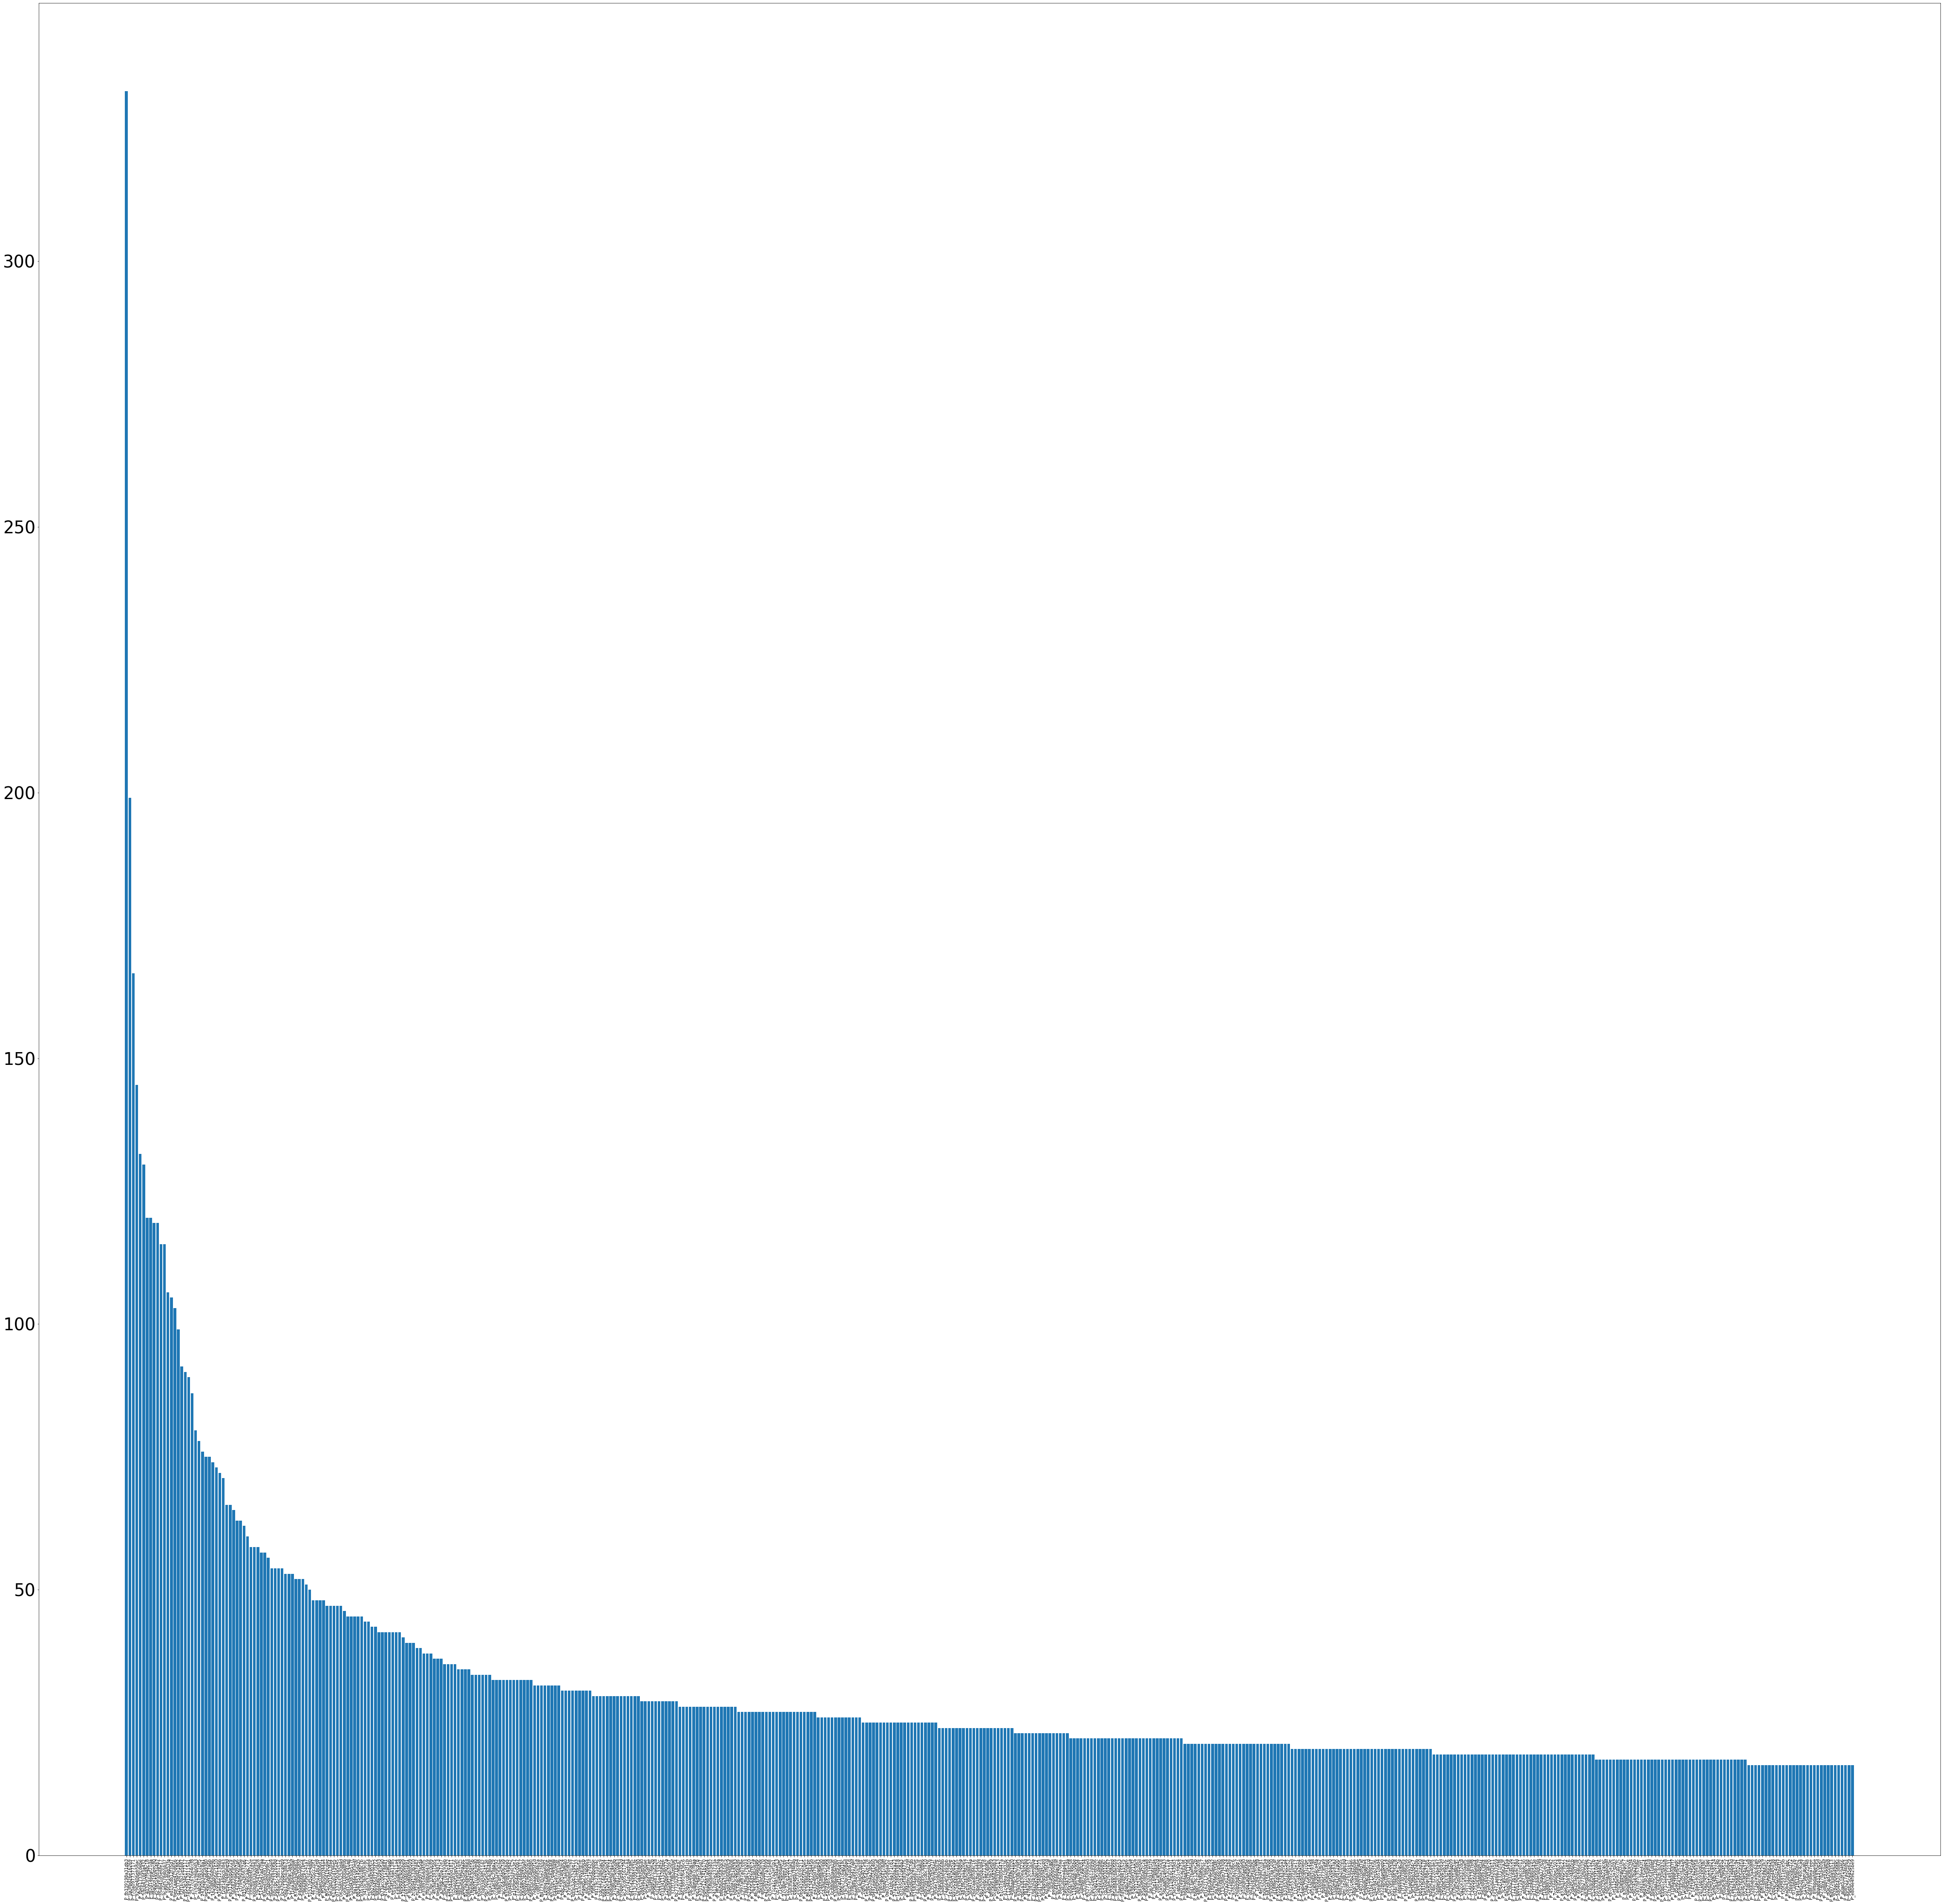

In [23]:
# Top 500 POIs with most place entries pointing to the same entity
plt.figure(figsize=(80, 80))
plt.bar(poi_entries[:500].index, poi_entries[:500].values)
plt.xticks(rotation=90)
plt.yticks(fontsize=40)
plt.show()

In [24]:
# Get more descriptive statistics details on the distribution
poi_entries.describe()

count    314948.000000
mean          2.266368
std           1.779295
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         332.000000
Name: id_x, dtype: float64

## Check how likely 2 place entries will have the same values if they match

In [25]:
# Proportion of matching pairs with the same values on specific columns
print('Matching pairs with the same latitude and longitude: ', len(pairs_from_train[(pairs_from_train['latitude_x'] == pairs_from_train['latitude_y']) & (pairs_from_train['longitude_x'] == pairs_from_train['longitude_y'])]) / npairs)
print('Matching pairs with the same name: ', len(pairs_from_train[pairs_from_train['name_x'] == pairs_from_train['name_y']]) / npairs)
print('Matching pairs with the same city: ', len(pairs_from_train[pairs_from_train['city_x'] == pairs_from_train['city_y']]) / npairs)
print('Matching pairs with the same country: ', len(pairs_from_train[pairs_from_train['country_x'] == pairs_from_train['country_y']]) / npairs)

Matching pairs with the same latitude and longitude:  0.009822167841658574
Matching pairs with the same name:  0.21032653237285942
Matching pairs with the same city:  0.5613301588737752
Matching pairs with the same country:  0.9776518327664405


We can see that it is not possible to conclude if 2 place entries match only depending on whether they have the same name or the same latitude and longitude. While almost all the matching entries have the same country, definitely we need to combine this with other information (e.g. name, city), otherwise there will be too many potential pairs and computational costs will be too high.

## Check similarities (Haversine and Levenshtein distances) of 2 place entries if they match

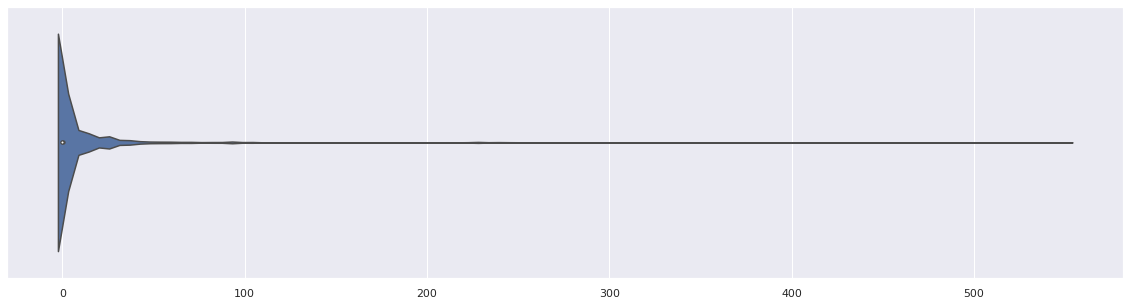

In [26]:
# Latitude and longitude values need to be transformed before calculating Haversine distance
loc_cols = ['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y']
pairs_from_train[loc_cols] = np.deg2rad(pairs_from_train[loc_cols])

# Visualize similarities in terms of different features
distance = np.vectorize(get_distance)(pairs_from_train['latitude_x'], pairs_from_train['longitude_x'],
                                      pairs_from_train['latitude_y'], pairs_from_train['longitude_y'])
create_violinplot(distance)

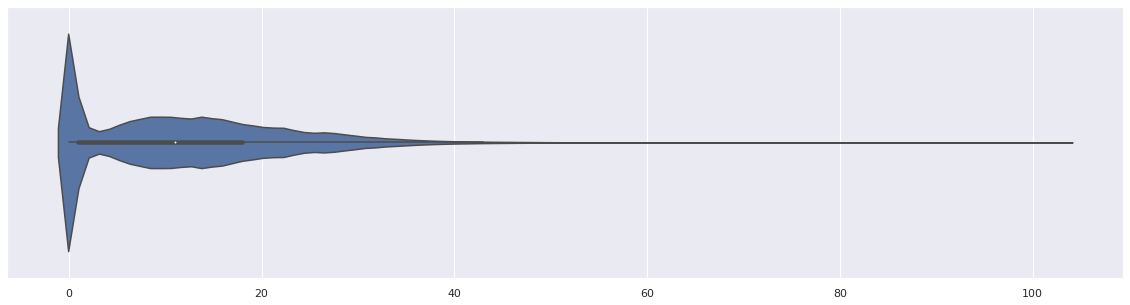

In [27]:
name_similarity = np.vectorize(Levenshtein.distance)(pairs_from_train['name_x'], pairs_from_train['name_y'])
create_violinplot(name_similarity)

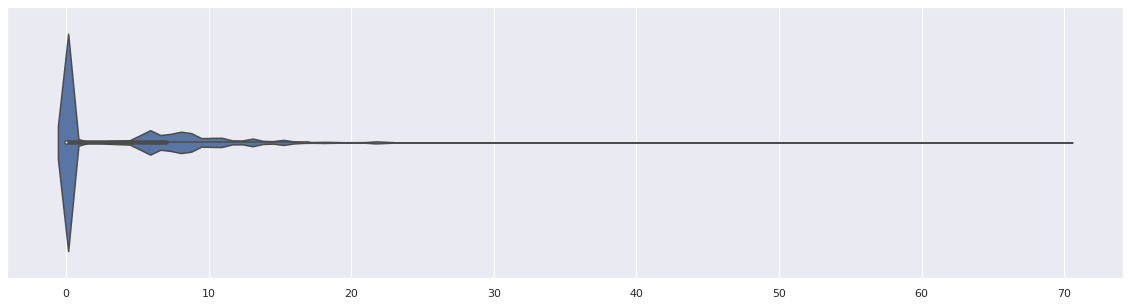

In [28]:
city_similarity = np.vectorize(Levenshtein.distance)(pairs_from_train['city_x'], pairs_from_train['city_y'])
create_violinplot(city_similarity)

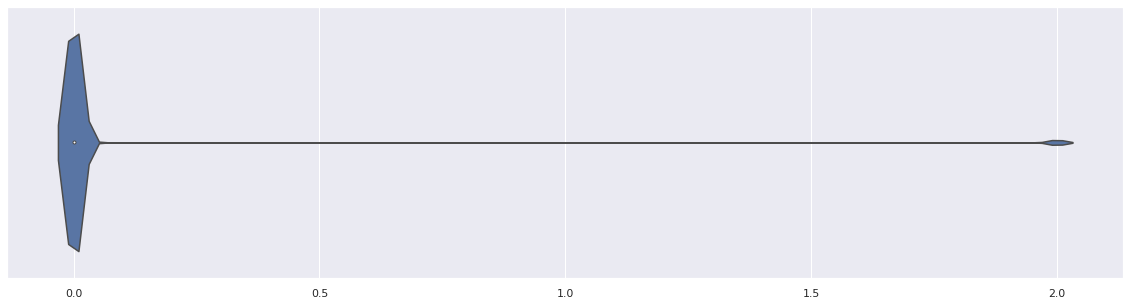

In [29]:
country_similarity = np.vectorize(Levenshtein.distance)(pairs_from_train['country_x'], pairs_from_train['country_y'])
create_violinplot(country_similarity)

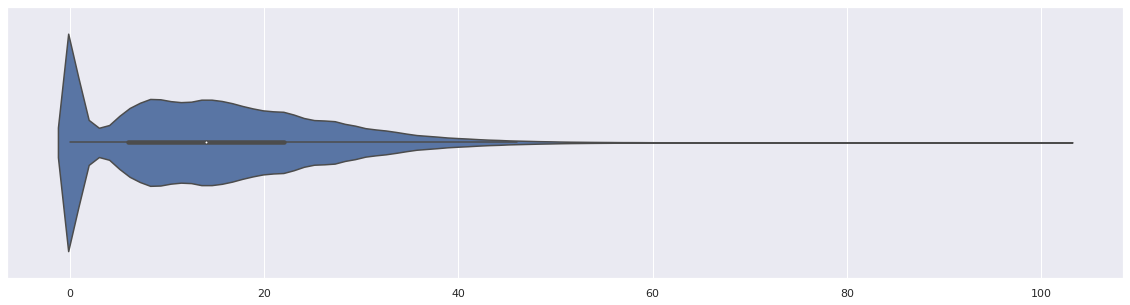

In [30]:
name_loc_similarity = np.vectorize(Levenshtein.distance)(pairs_from_train['name_loc_x'], pairs_from_train['name_loc_y'])
create_violinplot(name_loc_similarity)

To have efficient indexing while trying to include most potential pairs, I will block on 'latitude' and 'name_loc'.

# Blocking and comparing pairs

For people who are not very familiar with blocking, I would like to explain why it is necessary before building a model.

You may notice for the project's purpose, we need to pair up the entries and compare them to see if they are really the same entities. The problem is that, if we pair up entries one by one, we will end up with over 600 billion pairs which are not possible to be processed efficiently. So we only want to pair up entries that have some kind of similarity (e.g. names) to avoid unnecessarily handling too much pairs.

Yes, we do not need this process if the dataset is not big or if the computer is powerful enough to handle such a great number of pairs. But most of the time in the real world with so much complicated data, this is a useful technique.

You may also read [this](https://vintasoftware.github.io/deduplication-slides/#1/4---Indexing) for visual presentations of different blocking algorithms and how they work.

In [31]:
# Block and get similarity scores on specific columns of potential pairs using recordlinkage
train_score_dfs = get_score(train_df)
train_score_dfs[0]

,id_1,id_2,name_score,latitude_score,longitude_score,address_score,city_score,country_score,categories_score
0,E_e614e493a785aa,E_db3a637789cdee,0.120000,0.999999,0.983524,0.233333,1.000000,1.0,0.396825
1,E_f6b46f687acaa9,E_db3a637789cdee,0.102041,0.999999,0.983524,0.233333,1.000000,1.0,0.317460
2,E_8b4f39c03e7115,E_86ebb4d26ed714,0.411765,0.999976,0.999991,0.193548,0.000000,1.0,0.200000
3,E_b8cf618b944115,E_2bd673de933dd9,0.050000,0.999988,0.000000,0.400000,0.222222,1.0,0.137255
4,E_bbed239b9e1617,E_bbb478e3efbb1d,0.068966,0.999980,0.000000,0.000000,0.000000,0.0,0.173913
...,...,...,...,...,...,...,...,...,...
139202,E_7aab5be6b8b4ac,E_6bfed2b3d023c9,0.133333,0.999986,0.882473,0.235294,0.222222,1.0,0.235294
139203,E_7aaba6ab52721e,E_08ad637495cae4,0.000000,0.999972,0.990868,0.000000,0.000000,1.0,0.100000
139204,E_7aabe9fde29ff3,E_146833f2ab87ad,0.115385,0.999982,0.000000,0.166667,0.235294,0.5,0.214286
139205,E_7aabf156384795,E_0445a328a7c17e,0.050000,1.000000,0.997726,0.300000,0.000000,1.0,0.000000


Since the output of get_score() does not have POIs in it, we need to include this information so we will know which pairs match.

In [32]:
def get_poi(x):
    """Get the POI from the place entry ID."""
    return train_df.loc[x, 'point_of_interest']

In [33]:
# Get the POIs of the pairs and check if they match
for df in train_score_dfs:
    df['poi_1'] = np.vectorize(get_poi)(df['id_1'])
    df['poi_2'] = np.vectorize(get_poi)(df['id_2'])
    df['match'] = (df['poi_1'] == df['poi_2']).astype('int64')

In [34]:
# Concatenate the chunked DataFrames generated by get_score() to form a combined one
train_score = pd.concat(train_score_dfs)
train_score.head()

,id_1,id_2,name_score,latitude_score,longitude_score,address_score,city_score,country_score,categories_score,poi_1,poi_2,match
0,E_e614e493a785aa,E_db3a637789cdee,0.120000,0.999999,0.983524,0.233333,1.000000,1.0,0.396825,P_2c7e90d27ceb87,P_0cf377a788ee7e,0
1,E_f6b46f687acaa9,E_db3a637789cdee,0.102041,0.999999,0.983524,0.233333,1.000000,1.0,0.317460,P_c1f68fb59797c5,P_0cf377a788ee7e,0
2,E_8b4f39c03e7115,E_86ebb4d26ed714,0.411765,0.999976,0.999991,0.193548,0.000000,1.0,0.200000,P_2bfe7498ea5bdf,P_2bfe7498ea5bdf,1
3,E_b8cf618b944115,E_2bd673de933dd9,0.050000,0.999988,0.000000,0.400000,0.222222,1.0,0.137255,P_344c04f9dd4790,P_8a5ecbc672e21b,0
4,E_bbed239b9e1617,E_bbb478e3efbb1d,0.068966,0.999980,0.000000,0.000000,0.000000,0.0,0.173913,P_0c8527d0c2df42,P_6faef2bfba5df6,0


# Training

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import joblib

In [36]:
# Create feature array
feat_cols = ['name_score', 'latitude_score', 'longitude_score', 'city_score', 
             'address_score', 'country_score', 'categories_score']

X = train_score[feat_cols].values

In [37]:
# Create target array
y = train_score['match'].values

# Explore positive samples
print('Number of matching pairs after blocking:', sum(y))
print('Proportion of positive samples:', sum(y) / len(y))

Number of matching pairs after blocking: 278569
Proportion of positive samples: 0.06670386152020794


About 6.6% of the potential pairs are real matches. This ratio is significantly higher than 0.00029% from the raw data (please refer to output of cell 17). But we still need to be aware of the serious imbalance between positive and negative samples.

Another important point is that among 1901006 matching pairs, only 278569 pairs are captured here. But that does not mean that we will definitely have a very low accuracy. If Place A is predicted to be the same location with Place B, and Place B be the same with Place C, all Place A, B and C will finally be grouped together even if Place A and C pair are not included here.

But still, this problem needs to be tackled. However, this poses a great challenge because when we try to include more pairs by increasing the window size in get_score(), the computational costs will increase drastically.

In [38]:
# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Perform RandomizedSearchCV to find the best parameters for my classifier

In [39]:
# Set up the parameters and distributions to sample from
params = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
          'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight': [1, 3, 5, 7],
          'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
          'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
          'scale_pos_weight': [1, 2, 5, 10]
         }

In [40]:
# Instantiate an XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', seed=42)

In [41]:
# Instantiate the RandomizedSearchCV object and fit the training data
cv = RandomizedSearchCV(estimator=clf,
                        param_distributions=params,
                        scoring='roc_auc',
                        n_iter=5,
                        verbose=3,
                        random_state=10
                        )
search= cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=5, scale_pos_weight=2;, score=0.974 total time=  48.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=5, scale_pos_weight=2;, score=0.974 total time=  47.8s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=5, scale_pos_weight=2;, score=0.974 total time=  46.7s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=5, scale_pos_weight=2;, score=0.973 total time=  48.9s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=5, scale_pos_weight=2;, score=0.974 total time=  47.5s
[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.15, max_depth=15, min_child_weight=7, scale_pos_weight=2;, score=0.976 total time= 4.0min
[CV 2/5] END colsample_bytree=0.4

In [42]:
# Have a look at the tuned parameters
best_params = search.best_params_
best_params

{'scale_pos_weight': 2,
 'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [43]:
# Build the model with parameters tuned by RandomizedSearchCV
# The model will stop training when its performance does not improve for 10 rounds
model = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_estimators=1000, **best_params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=True, early_stopping_rounds=10)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-logloss:0.65114	validation_1-logloss:0.65141
[1]	validation_0-logloss:0.61231	validation_1-logloss:0.61283
[2]	validation_0-logloss:0.57988	validation_1-logloss:0.58057
[3]	validation_0-logloss:0.54962	validation_1-logloss:0.55049
[4]	validation_0-logloss:0.52036	validation_1-logloss:0.52149
[5]	validation_0-logloss:0.49443	validation_1-logloss:0.49575
[6]	validation_0-logloss:0.47097	validation_1-logloss:0.47237
[7]	validation_0-logloss:0.44741	validation_1-logloss:0.44902
[8]	validation_0-logloss:0.42680	validation_1-logloss:0.42860
[9]	validation_0-logloss:0.40647	validation_1-logloss:0.40857
[10]	validation_0-logloss:0.38832	validation_1-logloss:0.39061
[11]	validation_0-logloss:0.37113	validation_1-logloss:0.37362
[12]	validation_0-logloss:0.35541	validation_1-logloss:0.35815
[13]	validation_0-logloss:0.34098	validation_1-logloss:0.34388
[14]	validation_0-logloss:0.32799	validation_1-logloss:0.33097
[15]	validation_0-logloss:0.31587	validation_1-logloss:0.31893
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

## Model evaluation and saving

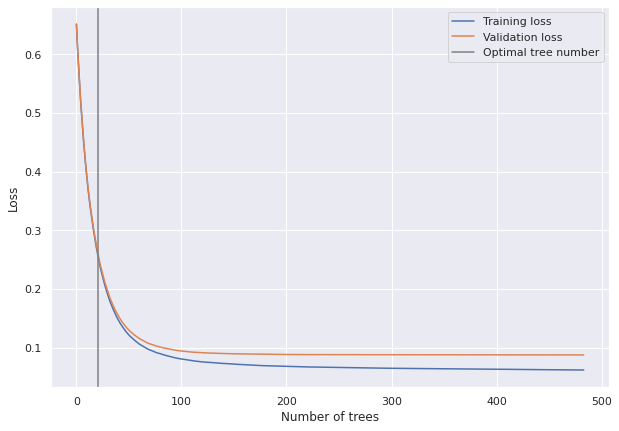

In [44]:
# Visualize the learning curve
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [45]:
# Predicting on testing set
# Test set was only used for evaluation instead of training during model.fit(), so I will still use X_test for final evaluation
y_pred = model.predict(X_test)

In [46]:
# Inspect the performance on testing set
report = classification_report(y_test, y_pred,output_dict=True)
pd.DataFrame(report)

,0,1,accuracy,macro avg,weighted avg
precision,0.979917,0.727879,0.963316,0.853898,0.963105
recall,0.980795,0.718760,0.963316,0.849777,0.963316
f1-score,0.980356,0.723291,0.963316,0.851823,0.963209
support,779527.000000,55714.000000,0.963316,835241.000000,835241.000000


In [47]:
# Compare with another model trained before
previous_model = joblib.load('../input/foursquare-my-data/previous_model.pkl')
previous_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [48]:
# Compare performance of previously trained model
y_pred_comp = previous_model.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_comp,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.974024,0.792336,0.964368,0.883180,0.961905
recall,0.988175,0.631278,0.964368,0.809726,0.964368
f1-score,0.981049,0.702696,0.964368,0.841872,0.962481
support,779527.000000,55714.000000,0.964368,835241.000000,835241.000000


In the previously trained model, it has a higher precision and lower recall on positive prediction, this is probably because it tends to make a negative prediction and is a conservative model, which is not ideal in real-world application. So I decided to use the newly-trained one.

In [49]:
# Save the model
model_file = 'saved_model.pkl'
joblib.dump(model, model_file)

['saved_model.pkl']